In [20]:
import numpy as np
import tensorflow as tf
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from IPython.display import Audio, display

In [21]:
# Define Constants
SAMPLE_RATE = 22050
DURATION = 3
N_MELS = 128
INPUT_SHAPE = (128, 128, 1)

In [22]:
#Feature Extraction
def extract_features(file_path, max_pad_len=128):
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MELS)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    pad_width = max_pad_len - mel_spec.shape[1]
    if pad_width > 0:
        mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec = mel_spec[:, :max_pad_len]
    return np.expand_dims(mel_spec, axis=-1), audio, sr  # Returning audio and sr for playback


In [ ]:
# Load audio file before attack
file_path = "E:/capstone/Deep_Fake/dd_total/fake/file25.wav"
original_features, original_audio, sr = extract_features(file_path)

In [25]:

# Play original audio
print("🎵 Playing Original Audio:")
display(Audio(original_audio, rate=sr))

🎵 Playing Original Audio:


In [27]:
# Build Model
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [39]:
# Load or Train Model
model = build_model()

In [40]:
# FGSM Attack Function
def fgsm_attack(model, image, label, epsilon=0.1):
    image = tf.convert_to_tensor(image.reshape((1, 128, 128, 1)), dtype=tf.float32)
    label = tf.one_hot(label, depth=2)
    label = tf.reshape(label, (1, 2))
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.CategoricalCrossentropy()(label, prediction)
    gradient = tape.gradient(loss, image)
    adversarial_image = image + epsilon * tf.sign(gradient)
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)
    return adversarial_image.numpy().reshape((128, 128, 1))

In [41]:
# Apply FGSM Attack
label = np.array([1])  # Assuming a label for demonstration
adversarial_features = fgsm_attack(model, original_features, label)

In [42]:
# Print warning message
print("⚠️ FGSM Attack Applied")
print("⚠️ Someone is hacking, please be careful!")

⚠️ FGSM Attack Applied
⚠️ Someone is hacking, please be careful!


In [43]:
# Convert adversarial features back to audio (Approximation using Inverse Mel)
attacked_audio = librosa.feature.inverse.mel_to_audio(adversarial_features.squeeze(), sr=sr)


In [44]:
# Play attacked audio
print("🎵 Playing Attacked Audio:")
display(Audio(attacked_audio, rate=sr))

🎵 Playing Attacked Audio:


In [45]:
# Plot Spectrograms
plt.figure(figsize=(10, 4))

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

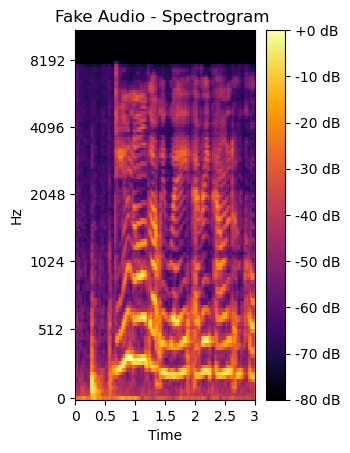

In [47]:
# Original Spectrogram
plt.subplot(1, 2, 1)
plt.title("Fake Audio - Spectrogram ")
librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(y=original_audio, sr=sr, n_mels=N_MELS), ref=np.max), sr=sr, x_axis='time', y_axis='mel', cmap='inferno')
plt.colorbar(format='%+2.0f dB')

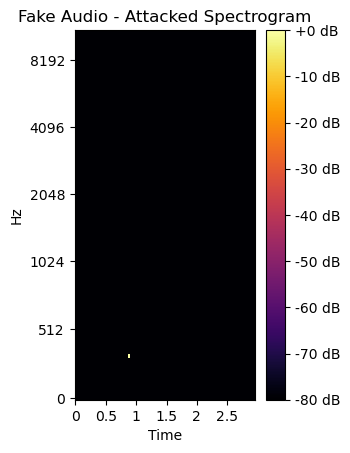

In [48]:
# Attacked Spectrogram
plt.subplot(1, 2, 2)
plt.title("Fake Audio - Attacked Spectrogram")
librosa.display.specshow(librosa.power_to_db(adversarial_features.squeeze(), ref=np.max), sr=sr, x_axis='time', y_axis='mel', cmap='inferno')
plt.colorbar(format='%+2.0f dB')

In [49]:

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>